In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import os

In [ ]:
generator_set = ["samcheonpo","yeongheung","yeongdong","gumi","gwangyanghang","dusan","gyeongsangUni","yecheon","goheungman"]

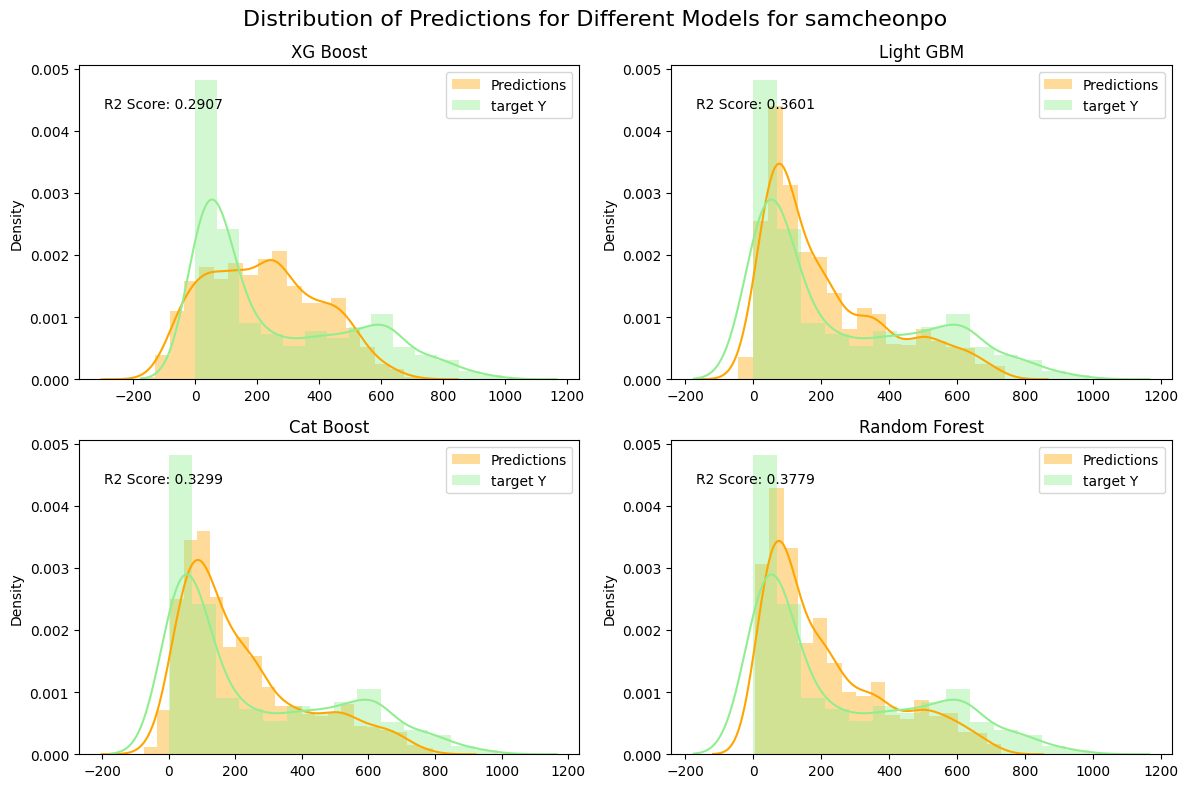

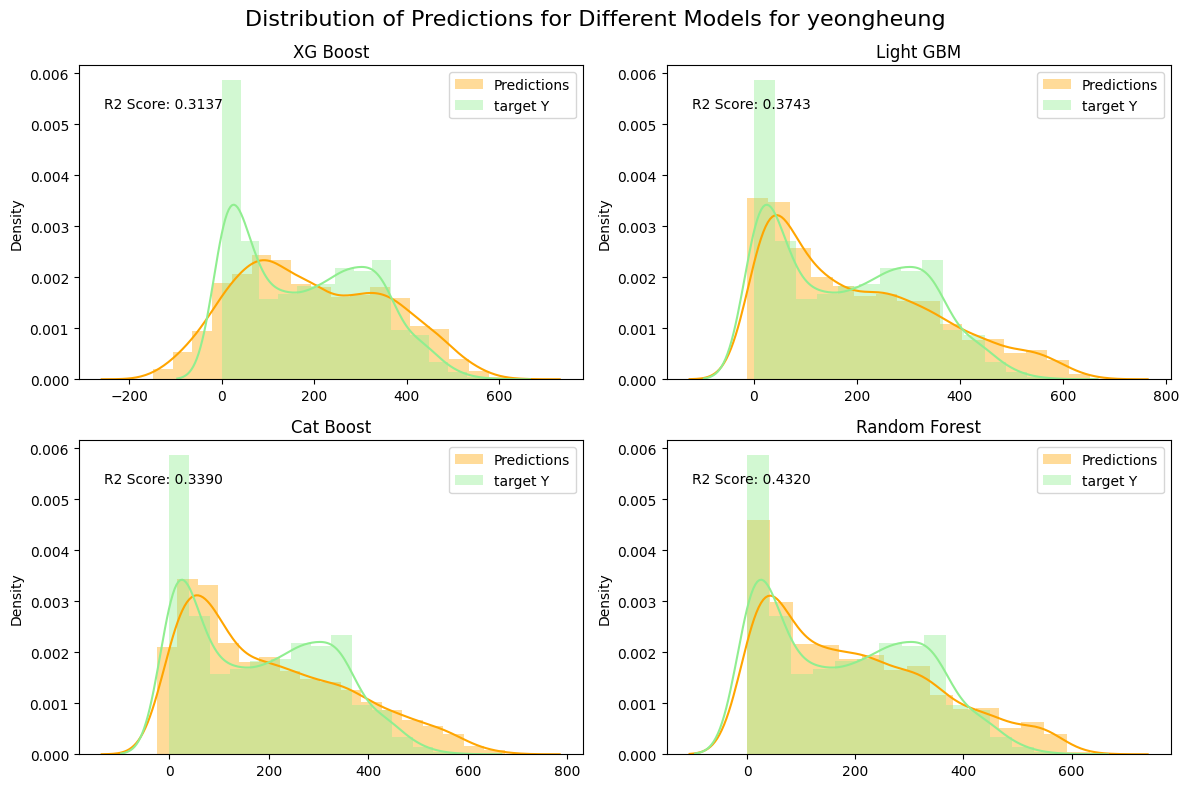

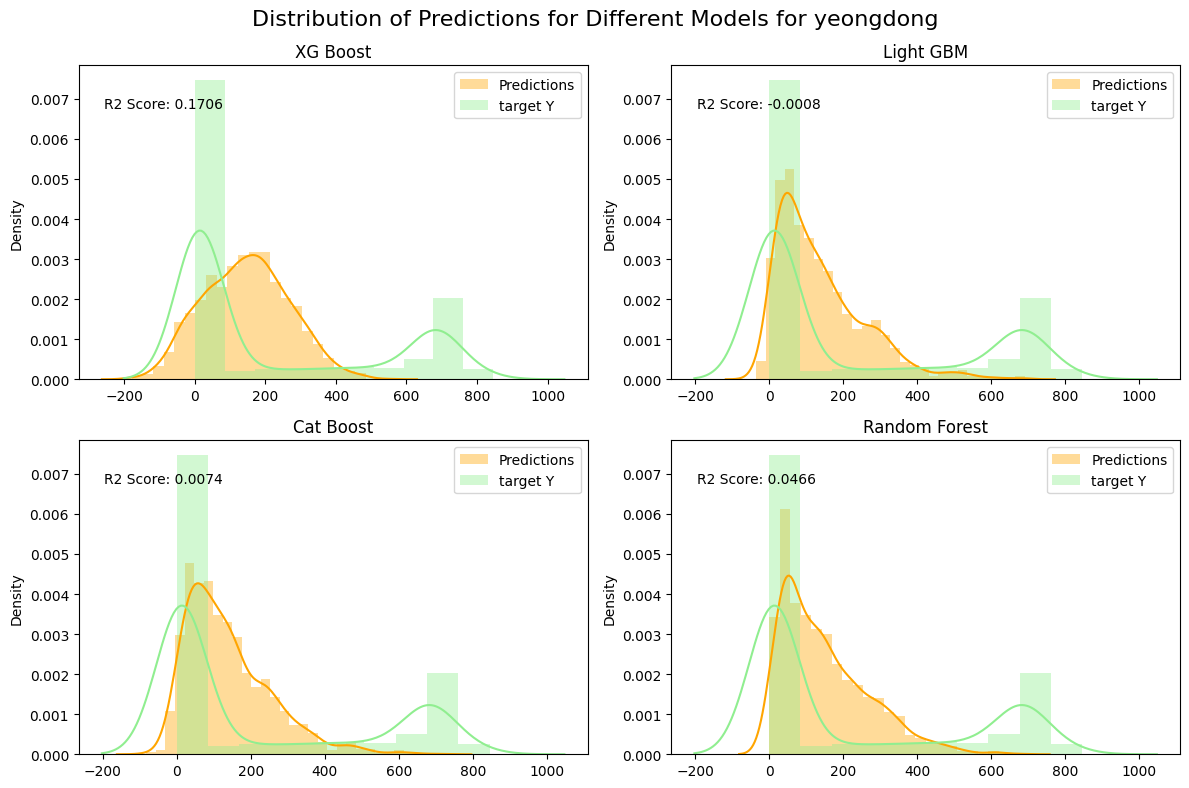

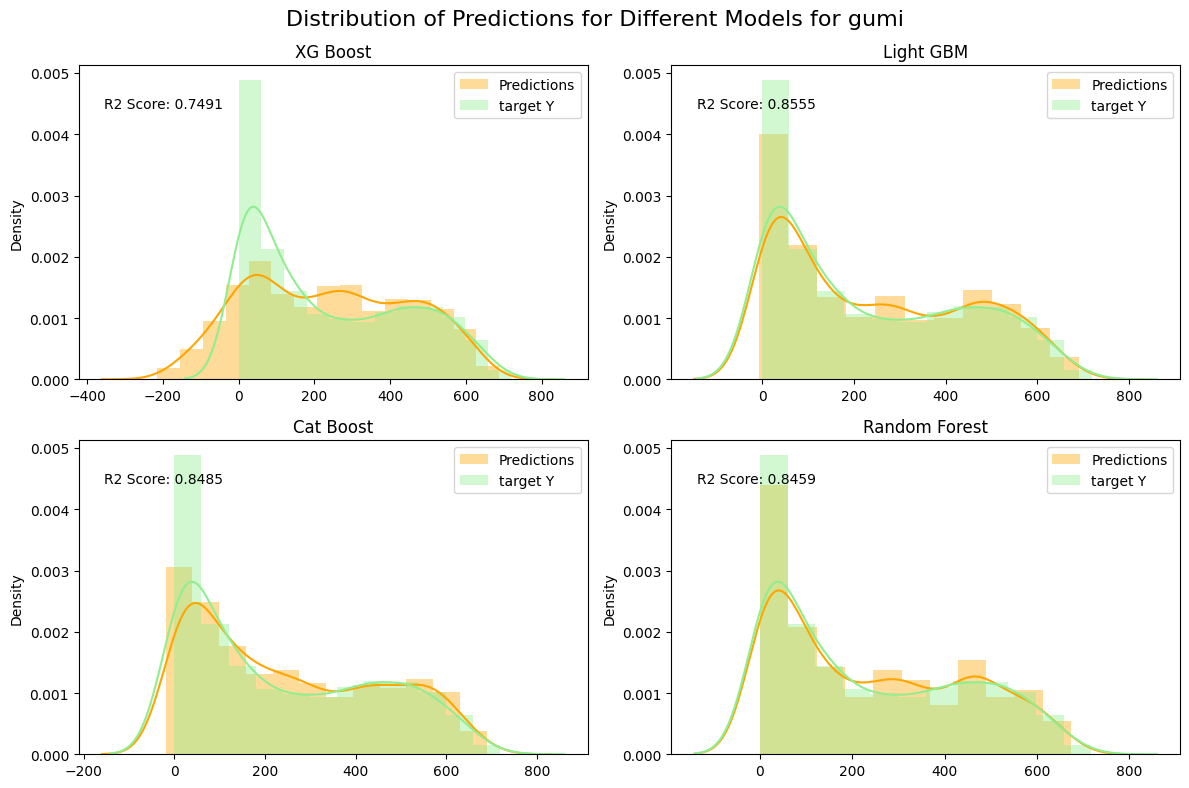

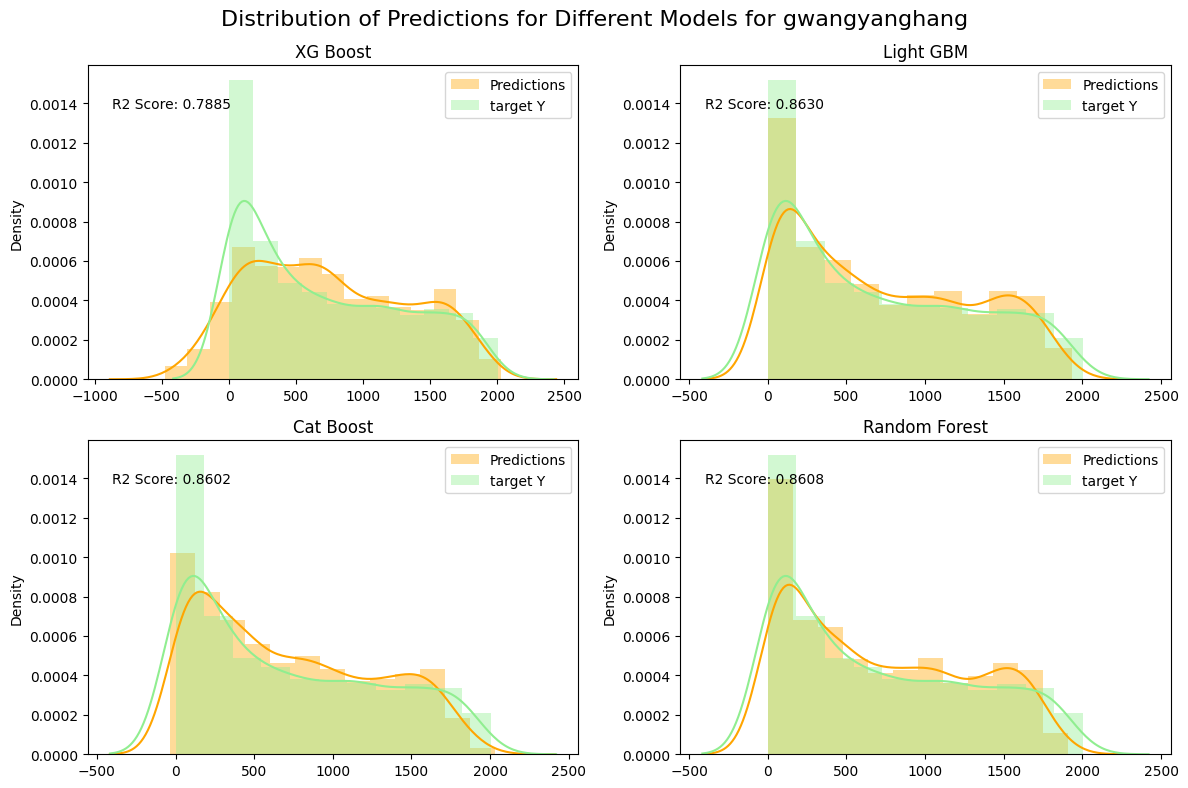

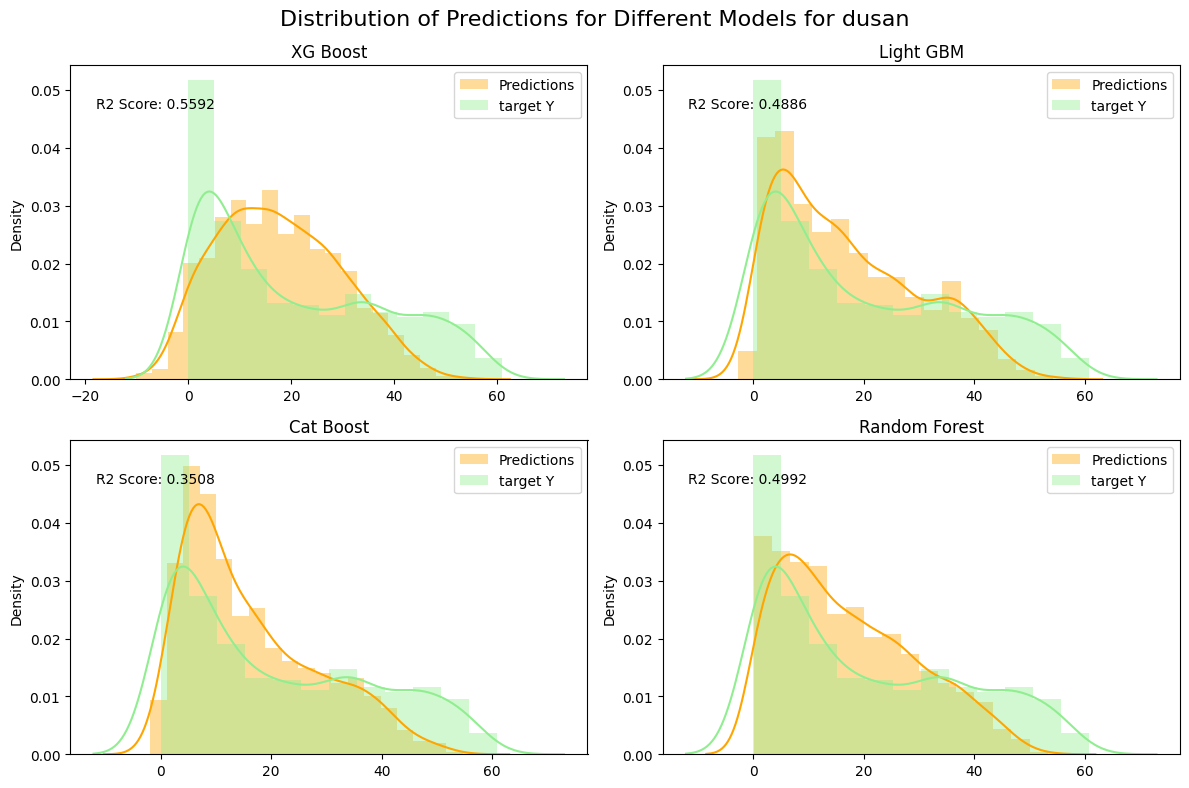

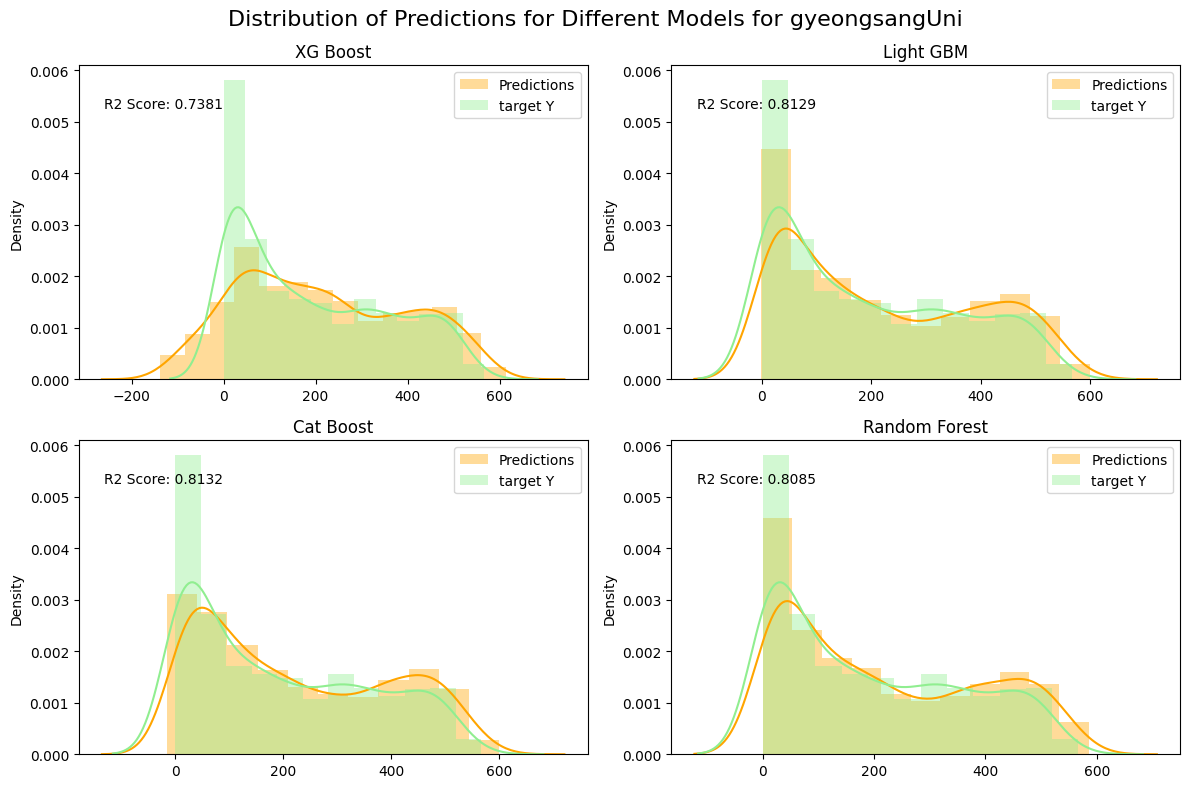

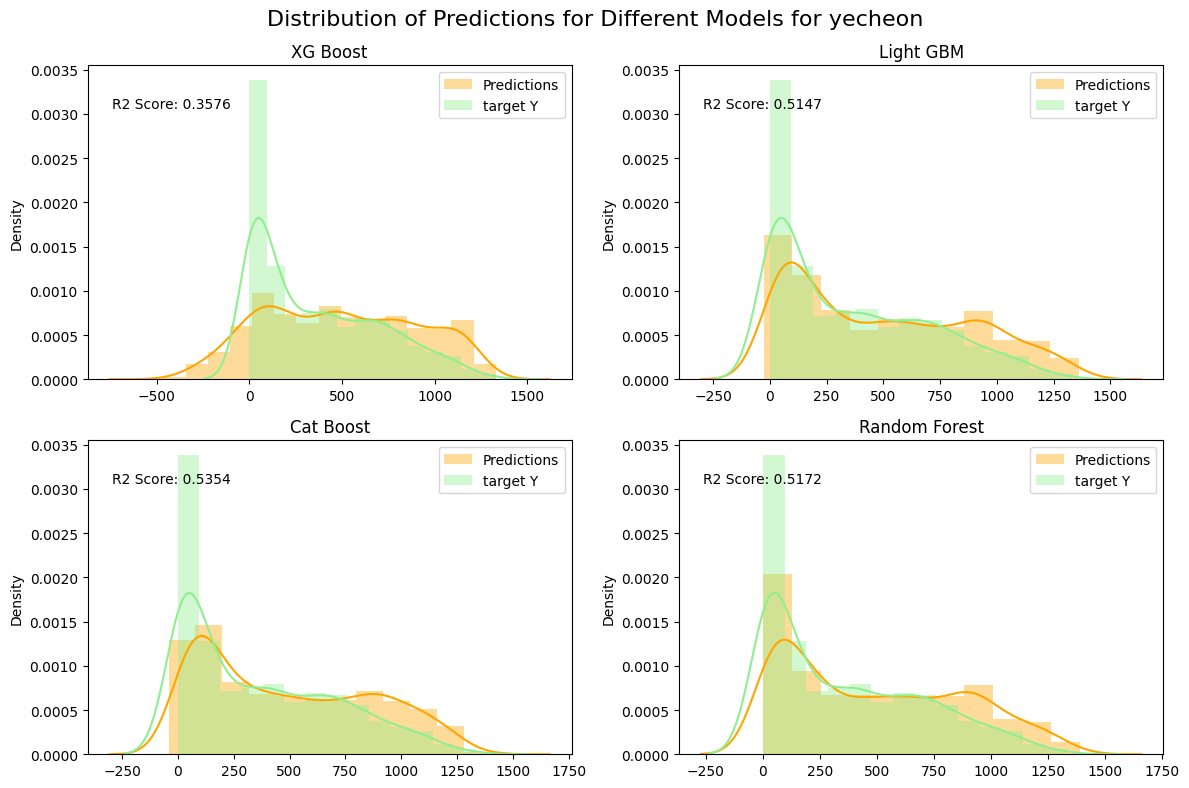

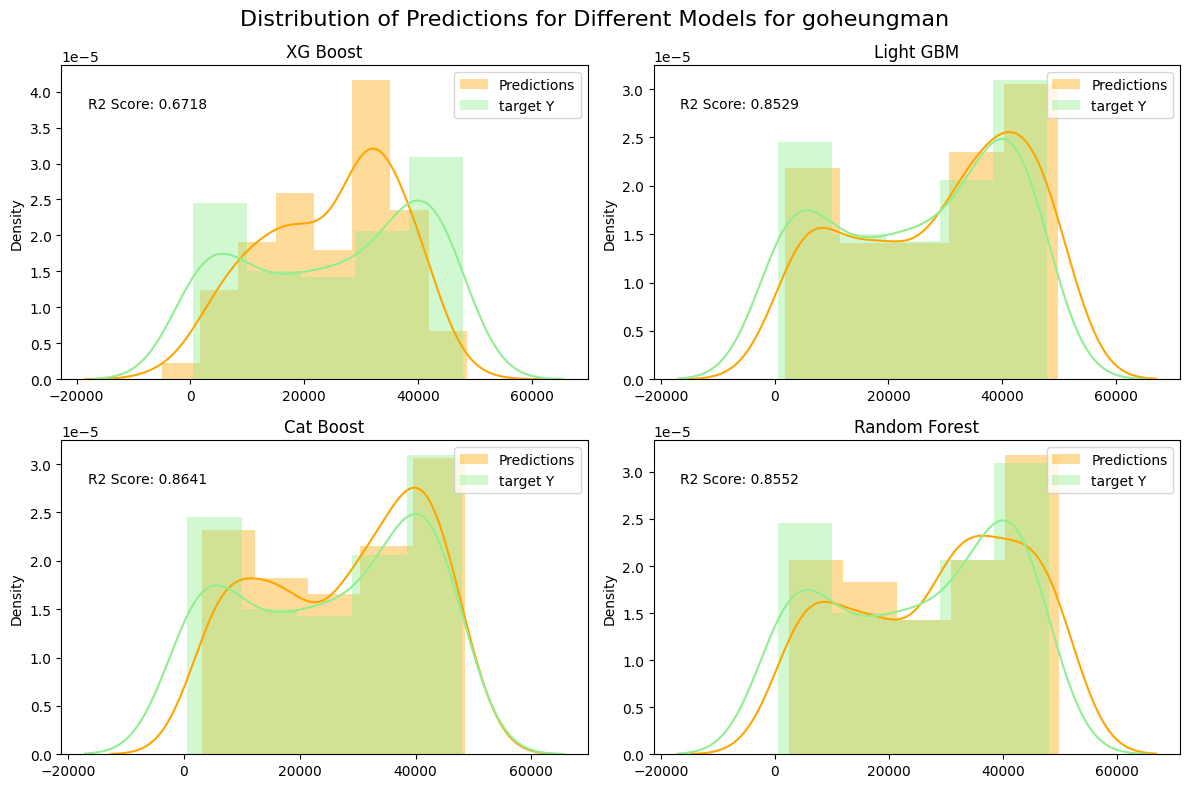

In [ ]:
# <Build 4 models for each generator & compare modles>

warnings.filterwarnings('ignore')

# iterate for each generator
for generator in generator_set:
  path = '/content/drive/MyDrive/하늘/data files/feature_added/'+generator+'.csv'

  df = pd.read_csv(path)
  df = df.drop('Unnamed: 0', axis=1)
  del_cols = ['date','year','month','day','hour','DoM','power_plant']
  df = df.drop(columns = del_cols)

  y_col = df['total_weighted_average_power']
  df = df.drop(columns = ['total_weighted_average_power'])
  df['total_weighted_average_power'] = y_col

  X=df.iloc[:,:-1]
  y=df['total_weighted_average_power']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

  scaler = MinMaxScaler()
  scaler.fit(X_train)
  scaler.transform(X_train)
  scaler.transform(X_test)

  # xg boost
  xgb_param = xgboost.XGBRegressor(colsample_bytree=0.055,
                             gamma=1.5,
                             learning_rate=0.02,
                             max_depth=12,
                             n_estimators=1000,
                             subsample=0.7,
                             booster='gbtree',
                             reg_alpha=0.0,
                             eval_metric = 'rmse',
                             silent=1,
                             random_state =7).fit(X_train,y_train)
  # light gbm
  lgb_param = lightgbm.LGBMRegressor(objective='regression',
                              num_leaves=144,
                              learning_rate=0.005,
                              n_estimators=1000,
                              max_depth=12,
                              metric='rmse',
                              is_training_metric=True,
                              max_bin = 55,
                              bagging_fraction = 0.8,
                              verbose=-1,
                              bagging_freq = 5,
                              feature_fraction = 0.9,
                              force_row_wise=True).fit(X_train,y_train)
  # cat boost
  cat = CatBoostRegressor(iterations=1000,
                              learning_rate=0.05,
                              depth=10,
                              eval_metric='RMSE',
                              random_seed=42,
                              logging_level='Silent').fit(X_train,y_train)
  # random forest
  rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train,y_train)

  # predict target
  xgb_param_pred = xgb_param.predict(X_test)
  lgb_param_pred = lgb_param.predict(X_test)
  cat_pred = cat.predict(X_test)
  rf_pred = rf.predict(X_test)

  # calculate R2 for each model
  xgb_param_score = r2_score(y_test,xgb_param_pred)
  lgb_param_score = r2_score(y_test,lgb_param_pred)
  cat_score = r2_score(y_test,cat_pred)
  rf_score = r2_score(y_test,rf_pred)

  preds = [xgb_param_pred, lgb_param_pred, cat_pred, rf_pred]
  scores = [xgb_param_score, lgb_param_score, cat_score, rf_score]
  model_names = ['XG Boost', 'Light GBM', 'Cat Boost', 'Random Forest']

  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
  fig.suptitle(f"Distribution of Predictions for Different Models for {generator}", fontsize=16)

  # plotting
  for ax, pred, score, model_name in zip(axes.flatten(), preds, scores, model_names):
      indexes_power_predicted = X_test.index
      original = np.array(df.loc[indexes_power_predicted, 'total_weighted_average_power'])

      sns.distplot(pred, color="orange", label="Predictions", hist=True, ax=ax)
      sns.distplot(original, color="lightgreen", label="target Y", hist=True, ax=ax)

      ax.set_title(f"{model_name}")
      ax.legend(loc='upper right')
      ax.text(0.05, 0.9, f'R2 Score: {score:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/하늘/results/model comparison/' + generator + '_model_comparison.png')
  plt.show()